***
#### Importing necessary libraries

In [2]:
import re
import itertools
import time
import timeit

import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit import Clbit
from qiskit.circuit.library import *
from qiskit.primitives import StatevectorSampler, Estimator
from qiskit.quantum_info import DensityMatrix

> Note: You must run this cell before running any other cells in this notebook.
***

# A Comparision Between Complete State Tomography and Shadow Tomography
***
## Complete State Tomography

### Overview

The aim of complete state tomography is to reconstruct a target quantum state through a series of projective measurements. In the classical setting where are a great deal of information can be learned from observing a state once and the object can be observed multiple times without risk of the previous measurement significantly perturbing to state effecting future measurement. In the quantum setting an a single measurement yields probabilistic outcomes (Born's rule) while after this measurement the previous state has effectively been destroyed and sent to the resulting measured state. Additionally, the number of parameters required to describe a quantum system scales exponentially in the size of the system. This means that the already large amount of measurements (and therefore copies of a state) required to approximate a single parameter must be repeated for each additional parameter which scales exponentially. Never the less, once the monuments task of measurement and reconstruction has been completed you are left with a good approximation of the prepared state and can now use it to estimate any property you wish. 

### Theory

For single-qubit states the general expression for their density matrices can be written uniquely as:
$$\hat{\rho} = \frac{1}{2} \sum_{i=0}^{3} S_i \hat{\sigma}_i. \tag{1}$$
Where $\hat{\sigma}_i$ are the Pauli matrices (Including the 2x2 identity matrix as $\hat{\sigma}_0$) and $S_i$ are the values given by:
$$S_i = Tr\{\hat{\sigma}_i\hat{\rho}\}. \tag{2}$$
It is also useful to note that, 
1. For all pure states: $\sum_{i=1}^{3} S_i^2 = 1$.
2. For mixed states: $\sum_{i=1}^{3} S_i^2 < 1$.
3. For the completely mixed state:  $\sum_{i=1}^{3} S_i^2 = 0$.
4. Due to the normalization condition for quantum states it is always the case that: $S_0^2 = 1$.

Equations (1) and (2) are from pages 4 and 5 of [Quantum State Tomography](#references). Proofs of (1) and (2) to be added in the future.

For a quantum state represented by density matrix $\hat{\rho}$ the expectation value for an observable $\hat{\Omega}$ is given by:
$$\langle \hat{\Omega} \rangle = \sum_{i} p_i \bra{i} \hat{\Omega} \ket{i} = Tr \{ \hat{\Omega} \hat{\rho} \}. \tag{3}$$
Thus, using (1) and (3), we can represent the density matrix for a single-qubit state as:
$$\hat{\rho} = \frac{1}{2} \sum_{i=0}^{3} \langle \hat{\sigma}_i \rangle \hat{\sigma}_i. \tag{4}$$

For multiple-qubit states the general expression for their density matrices can be written as:
$$ \hat{\rho} = \frac{1}{2^n} \sum_{i_1,i_2,\dots,i_n = 0}^{3} S_{i_1,i_2,\dots,i_n} \hat{\sigma}_{i_1} \otimes \hat{\sigma}_{i_2} \otimes \dots \hat{\sigma}_{i_n}. \tag{5}$$
Where $\hat{\sigma}_i$ are still the Pauli matrices (Including the 2x2 identity matrix as $\hat{\sigma}_0$) and $S_{i_1,i_2,\dots,i_n}$ are the values given by:
$$ S_{i_1,i_2,\dots,i_n} = Tr\{ \hat{\sigma}_{i_1,i_2,\dots,i_n} \hat{\rho} \} = Tr\{ (\hat{\sigma}_{i_1} \otimes \hat{\sigma}_{i_2} \otimes \dots \hat{\sigma}_{i_n}) \hat{\rho} \} \tag{6}$$

Equations (5) and (6) are from page 11 of [Quantum State Tomography](#references).

Similarly, using (5) and (6), we can represent the density matrix for an n-qubit state as:
$$ \hat{\rho} = \frac{1}{2^n} \sum_{i_1,i_2,\dots,i_n = 0}^{3} \langle \hat{\sigma}_{i_1,i_2,\dots,i_n} \rangle \hat{\sigma}_{i_1} \otimes \hat{\sigma}_{i_2} \otimes \dots \hat{\sigma}_{i_n}. \tag{7}$$

> Note: Above we only considered the orthogonal measurement bases of the pauli matrices. We are not constrained to orthogonal measurement bases and can instead use any set of linearly independent projective measurements (see pages 5 and 6 of [Quantum State Tomography](#references) for the single-qubit case and pages 11 and 12 of [Quantum State Tomography](#references) for the multiple-qubit case.).

### The "Algorithm"

#### Function for generating an approximation of the $\rho$ prepared by the input circuit using complete state tomography as describe in [Quantum State Tomography](#references)

In [8]:
def complete_state_tomography(circuit, samples):
    """
    Perform complete state tomography on a state prepared by a quantum circuit. 
    
    Args:
        circuit (QuantumCircuit): The quantum circuit that prepares the state.
        samples (int): The number of samples to use in the tomography.

    Returns:
        np.ndarray: The density matrix of the state.
    """

    # The Pauli matrices.
    I = [[1,0],[0,1]]
    X = [[0,1],[1,0]]
    Y = [[0,-1j],[1j,0]]
    Z = [[1,0],[0,-1]]

    # Get the number of qubits in the circuit.
    num_qubits = circuit.num_qubits

    # Create a matrix to store the density matrix.
    rho = np.zeros((2**num_qubits, 2**num_qubits), dtype=complex)

    # Generate the measurement scheme using the cartesian product.
    measurement_schemes = []

    for measurement in (itertools.product(['I','X','Y','Z'], repeat=num_qubits)):
        measurement_schemes.append(measurement)

    # An array to store the measurement results.
    results = np.zeros(4**num_qubits)

    # Create a estimator to simulate the quantum circuit a "samples" amount of shots.
    sampler = StatevectorSampler(default_shots = samples)

    # Perform the measurements. This generates the S coefficients in equation (6) above.
    for i, measurement in enumerate(measurement_schemes):

        # Apply the measurement scheme to the qubits
        qc = QuantumCircuit.copy(circuit)

        for j in range(num_qubits):
            if measurement_schemes[i][j] == 'X':
                qc.h(j)
            elif measurement_schemes[i][j] == 'Y':
                qc.s(j)
                qc.h(j)
            else:
                continue

        qc.measure_all()

        # Run the sampler on the quantum circuit and store the result.
        result = sampler.run([qc]).result()[0]

        # Store the bit-strings representing the measured basis states.
        counts = result.data.meas.get_counts()  

        # Calculate the expectation value of the measurement.
        expectation = 0
        for key in counts.keys():
            sign = 1
            for j in range(num_qubits):
                if (key[::-1])[j] == '1' and measurement_schemes[i][j] != 'I':
                    sign *= -1
                    
            expectation += sign*counts[key]
        
        results[i] = expectation/samples
        
    # Calculate the density matrix. This is just an implementation of equation (5) above.
    for i, measurement in enumerate(measurement_schemes):

        o = [1]
        for j in measurement:
            match j:
                case 'I':
                    o = np.kron(o, I)
                case 'X':
                    o = np.kron(o, X)
                case 'Y':
                    o = np.kron(o, Y)
                case 'Z':
                    o = np.kron(o, Z)
        rho += results[i] * o

    return rho/2**num_qubits

Using the function ``operator_distance`` we can determine how "close" the reconstructed state is to the true state.

In [9]:
def operator_distance(A, B):
    """
    Calculate the distance between two operators using the Frobenius norm.

    Args:
        A (np.array): The first operator.
        B (np.array): The second operator.

    Returns:
        float: The distance between the two operators.
    """

    return np.linalg.norm((A - B), ord = 'fro')

### Examples

#### With an arbitrary single qubit state

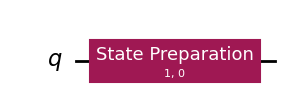

In [10]:
# Instantiate a quantum register for a single qubit.
single_qubit_qr = QuantumRegister(1, 'q')

# Coefficients for the arbitrary state.
a = 1
b = 0

# Create a quantum circuit which prepares the single qubit state into an arbitrary state based on coefficients a and b.
single_qubit_qc = QuantumCircuit(single_qubit_qr)
single_qubit_qc.prepare_state(state = [a/(np.sqrt(a**2 + b**2)), b/(np.sqrt(a**2 + b**2))], qubits = [0])

# Draw the circuit in mpl (matplotlib).
single_qubit_qc.draw('mpl')

In [11]:
rho_true = DensityMatrix.from_instruction(single_qubit_qc)
print("True density matrix:")
print(rho_true.data)

shots = 1000
rho_tomo = complete_state_tomography(single_qubit_qc, shots)
print("\nDensity matrix from tomography:")
print(np.round(rho_tomo, 2))

print("\nDistance between the true and tomography density matrices:")
print(np.round(operator_distance(rho_true.data, rho_tomo), 4))

print("\nTotal copies of the state used:")
print(4**single_qubit_qr.size * shots)

True density matrix:
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

Density matrix from tomography:
[[1.+0.j 0.+0.j]
 [0.-0.j 0.+0.j]]

Distance between the true and tomography density matrices:
0.0032

Total copies of the state used:
4000


#### With a Bell state

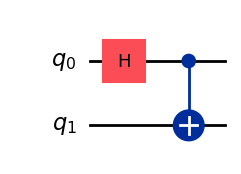

In [12]:
# Instantiate a quantum register with two qubits.
bell_state_qr = QuantumRegister (2, 'q')

# Create a quantum circuit with a hadamard gate acting on qubit 0
# and a CNOT gate with control qubit 0 and target qubit 1. This will prepare a bell state.
bell_state_qc = QuantumCircuit(bell_state_qr)
bell_state_qc.h(0)
bell_state_qc.cx(0, 1)

# Draw the ciruit in mpl (matplotlib).
bell_state_qc.draw("mpl")

In [13]:
rho_true = DensityMatrix.from_instruction(bell_state_qc)
print("True density matrix:")
print(rho_true.data)

shots = 1000
rho_tomo = complete_state_tomography(bell_state_qc, shots)
print("\nDensity matrix from tomography:")
print(np.round(rho_tomo, 2))

print("\nDistance between the true and tomography density matrices:")
print(np.round(operator_distance(rho_true.data, rho_tomo), 4))

print("\nTotal copies of the state used:")
print(4**bell_state_qr.size * shots)

True density matrix:
[[0.5+0.j 0. +0.j 0. +0.j 0.5+0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0.5+0.j 0. +0.j 0. +0.j 0.5+0.j]]

Density matrix from tomography:
[[ 0.48+0.j   -0.02+0.02j -0.  +0.j    0.5 +0.01j]
 [-0.02-0.02j -0.02+0.j    0.  -0.j   -0.02-0.01j]
 [-0.  -0.j    0.  +0.j    0.02+0.j    0.01-0.02j]
 [ 0.5 -0.01j -0.02+0.01j  0.01+0.02j  0.52+0.j  ]]

Distance between the true and tomography density matrices:
0.0644

Total copies of the state used:
16000


#### With a GHZ state

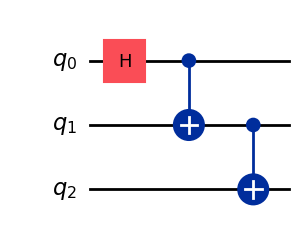

In [14]:
# Instantiate a quantum register with three qubits.
ghz_state_qr = QuantumRegister (3, 'q')

# Create a quantum circuit with a hadamard gate acting on qubit 0,
# a CNOT gate with control qubit 0 and target qubit 1,
# and a CNOT gate with control qubit 1 and target qubit 2. This will prepare a GHZ state.
ghz_state_qc = QuantumCircuit(ghz_state_qr)
ghz_state_qc.h(0)
ghz_state_qc.cx(0, 1)
ghz_state_qc.cx(1, 2)

# Draw the ciruit in mpl (matplotlib).
ghz_state_qc.draw("mpl")

In [15]:
rho_true = DensityMatrix.from_instruction(ghz_state_qc)
print("True density matrix:")
print(rho_true.data)

shots = 1000
rho_tomo = complete_state_tomography(ghz_state_qc, shots)
print("\nDensity matrix from tomography:")
print(np.round(rho_tomo, 2))

print("\nDistance between the true and tomography density matrices:")
print(np.round(operator_distance(rho_true.data, rho_tomo), 4))

print("\nTotal copies of the state used:")
print(4**ghz_state_qr.size * shots)

True density matrix:
[[0.5+0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0.5+0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0.5+0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0.5+0.j]]

Density matrix from tomography:
[[ 0.5 +0.j    0.01-0.j   -0.  -0.02j  0.  -0.01j -0.01+0.01j  0.01-0.01j
  -0.  +0.j    0.5 +0.j  ]
 [ 0.01+0.j    0.  +0.j    0.  +0.01j  0.  -0.j    0.  +0.j    0.  +0.j
   0.  +0.j   -0.  -0.01j]
 [-0.  +0.02j  0.  -0.01j  0.01+0.j    0.  +0.01j  0.01-0.01j  0.  +0.02j
   0.01+0.j   -0.01-0.01j]
 [ 0.  +0.01j  0.  +0.j    0.  -0.01j -0.  +0.j    0.  +0.01j -0.01+0.j
   0.01+0.01j  0.  +0.02j]
 [-0.01-0

***
## Shadow Tomography

### Overview

For many situations a complete description of a quantum state is not of interest but rather the expectation values of some set of observables. In a paper titled *Shadow Tomography of Quantum States* Scott Aaronson introduces the idea that a complete description of a state is not required to accurately estimate some subset of all target observables on the state. Then in a paper titled *Predicting Many Properties of a Quantum System from Very Few Measurements* Huang, Kueng, and Preskill develop and prove the efficiency of the method of classical shadows.

### Theory

## The Method of Classical Shadows

### Generating the Shadow

#### Function for generating the classical shadow

In [16]:
def generate_classical_shadow(circuit, shadow_size):
    """
    Adapted from https://pennylane.ai/qml/demos/tutorial_classical_shadows/.
    Given a quantum circuit, this function creates a collection of bit-strings generated by random single-qubit Pauli measurements and records the associated random pauli measurement.

    Args:
        circuit (QuantumCircuit): The quantum circuit which resulting state we wish to estimate.
        shadow_size (int): The number of random Pauli measurements to be taken.
        num_qubits (int): The number of qubits in the circuit.

    Returns:
        np.ndarray: A matrix of shape (shadow_size, num_qubits) where each row is a bit-string representing the result of a random Pauli measurement on the qubits.
        np.ndarray: A matrix of shape (shadow_size, num_qubits) where each row is a sequence of integers representing the Pauli measurement scheme used to generate the corresponding bit-string in the first matrix.
    """

    # Get the number of qubits in the circuit.
    num_qubits = circuit.num_qubits

    # Generate the measurement scheme. This is the random Pauli measurements that will be done on the qubits after each shot of the circuit.
    measurement_schemes = np.random.randint(0, 3, size = (shadow_size, num_qubits))

    # Create a matrix to store the results of the measurements.
    measurements = np.zeros(shape = (shadow_size, num_qubits))

    # Create a sampler to simulate the quantum circuit on a single shot.
    sampler = StatevectorSampler(default_shots=1)

    # List to store the circuits for each measurement scheme.
    circuits = []

    # Generate the circuits for each measurement scheme.
    for i in range(shadow_size):

        # Apply the measurement scheme to the qubits
        qc = QuantumCircuit.copy(circuit)

        for j in range(num_qubits):
            if measurement_schemes[i][j] == 0:
                qc.h(j)
            elif measurement_schemes[i][j] == 1:
                qc.s(j)
                qc.h(j)
            else:
                continue

        qc.measure_all()

        circuits.append(qc)

    # Simulate the circuits and store the results.
    # Run the sampler on the quantum circuit and store the result.
    results = sampler.run(circuits).result()

    # Process he results of the measurements. Convert the bit-strings to eigenvalues of the observable.
    for i, result in enumerate(results):

        # Store the bit-strings representing the measured basis states. Because the sampler is configured to run the circuit once, there is only one result.
        counts = result.data.meas.get_counts()   

        # Get the single bit-string.
        states = list(list(counts.keys())[0])
        # The bit string is ordered with qubit n on the left and qubit 0 on the right. We want to reverse this order.
        states.reverse()

        # Store the results of the measurements as the eigen values of the observable.
        for j in range(num_qubits):
            measurements[i][j] = 1 if states[j] == '0' else -1

    return measurements, measurement_schemes

> Note: In my implementation of the classical shadow protocol I use a measurement procedure consisting of random single-qubit (local) Clifford circuits (which are equivalent to measuring a random Pauli observable). I chose this procedure due its ease of implementation but other procedures offer different benefits, some of which are disused in [Predicting Many Properties of a Quantum System from Very Few Measurements](#references).

#### Function for reconstructing the states density matrix from the classical shadow

This is not the intended use of the classical shadow protocol and is additionally not the goal of shadow tomography. However, it serves as a useful test of the functionality of the generation of classical shadows.

In [17]:
def reconstruct_state(shadow):
    """
    Adapted from https://pennylane.ai/qml/demos/tutorial_classical_shadows/
    Given a classical shadow, this function reconstructs an approximation of the density matrix of the quantum state.
    
    Args:
        shadow (tuple): A tuple containing the classical shadow generated by the function generate_classical_shadow. The first element is a matrix of shape (shadow_size, num_qubits) where each row is a bit-string representing the result of a random Pauli measurement on the qubits. The second element is a matrix of shape (shadow_size, num_qubits) where each row is a sequence of integers representing the Pauli measurement scheme used to generate the corresponding bit-string in the first matrix.

    Returns:
        np.array: An approximation of the density matrix of the quantum state.
    """

    # Unpack the shadow.
    measurements, measurement_schemes = shadow

    # Get the shadow size.
    shadow_size = measurements.shape[0]
    # Get the number of qubits.
    num_qubits = measurements.shape[1]

    # Computational basis states.
    zero_state = np.matrix([[1,0],[0,0]], dtype=complex)
    one_state = np.matrix([[0,0],[0,1]], dtype=complex)

    # Local qubit unitaries. 
    phase_z = np.matrix([[1,0],[0,-1j]], dtype=complex)
    hadamard = np.matrix([[1,1],[1,-1]], dtype=complex)/np.sqrt(2)
    identity = np.matrix([[1,0],[0,1]], dtype=complex)

    # Rotations to measure each of the paulis.
    X = hadamard
    Y = hadamard @ phase_z
    Z = identity

    # Tomographically complete set of unitaries. (The pauli basis is tomographically complete.) 
    unitary_ensemble = [X, Y, Z]

    # Array to store the estimated density matrix.
    rho_estimated = np.zeros((2**num_qubits, 2**num_qubits), dtype=complex)

    for i in range(shadow_size):

        # Array to store the density matrix at each snapshot.
        rho_snapshot = [1]

        for j in range(num_qubits):

            # Implementation of formula S44 from the preskill paper.
            U = unitary_ensemble[measurement_schemes[i][j]]
            if measurements[i][j] == 1:
                b_state = zero_state
            else:
                b_state = one_state

            rho_local = 3 * (U.H @ b_state @ U) - identity

            rho_snapshot = np.kron(rho_snapshot, rho_local)

        # Average all the inverted basis states to get an approximation of the density matrix.
        rho_estimated += rho_snapshot/shadow_size

    return rho_estimated

### Testing the shadow generation with state reconstruction. 

#### With an arbitrary single qubit state

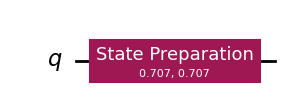

In [18]:
# Instantiate a quantum register for a single qubit.
single_qubit_qr = QuantumRegister(1, 'q')

# Coefficients for the arbitrary state.
a = 1
b = 1

# Create a quantum circuit which prepares the single qubit state into an arbitrary state based on coefficients a and b.
single_qubit_qc = QuantumCircuit(single_qubit_qr)
single_qubit_qc.prepare_state(state = [a/(np.sqrt(a**2 + b**2)), b/(np.sqrt(a**2 + b**2))], qubits = [0])

# Draw the circuit in mpl (matplotlib).
single_qubit_qc.draw('mpl')

In [19]:
rho_true = DensityMatrix.from_instruction(single_qubit_qc)
print("True density matrix:")
print(rho_true.data)

shadow_size = 1000
shadow = generate_classical_shadow(single_qubit_qc, shadow_size)
rho_shadow = reconstruct_state(shadow)
print("\nDensity matrix from shadow tomography:")
print(np.round(rho_shadow, 2))

print("\nDistance between the true and shadow tomography density matrices:")
print(np.round(operator_distance(rho_true.data, rho_shadow), 4))

print("\nTotal copies of the state used:")
print(shadow_size)

True density matrix:
[[0.5+0.j 0.5+0.j]
 [0.5+0.j 0.5+0.j]]

Density matrix from shadow tomography:
[[0.52+0.j   0.48+0.01j]
 [0.48-0.01j 0.48+0.j  ]]

Distance between the true and shadow tomography density matrices:
0.0362

Total copies of the state used:
1000


#### With a Bell state

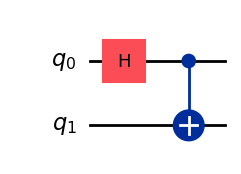

In [20]:
# Instantiate a quantum register with two qubits.
bell_state_qr = QuantumRegister (2, 'q')

# Create a quantum circuit with a hadamard gate acting on qubit 0
# and a CNOT gate with control qubit 0 and target qubit 1. This will prepare a bell state.
bell_state_qc = QuantumCircuit(bell_state_qr)
bell_state_qc.h(0)
bell_state_qc.cx(0, 1)

# Draw the ciruit in mpl (matplotlib).
bell_state_qc.draw("mpl")

In [21]:
rho_true = DensityMatrix.from_instruction(bell_state_qc)
print("True density matrix:")
print(rho_true.data)

shadow_size = 1000
shadow = generate_classical_shadow(bell_state_qc, shadow_size)
rho_shadow = reconstruct_state(shadow)
print("\nDensity matrix from shadow tomography:")
print(np.round(rho_shadow, 2))

print("\nDistance between the true and shadow tomography density matrices:")
print(np.round(operator_distance(rho_true.data, rho_shadow), 4))

print("\nTotal copies of the state used:")
print(shadow_size)

True density matrix:
[[0.5+0.j 0. +0.j 0. +0.j 0.5+0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0.5+0.j 0. +0.j 0. +0.j 0.5+0.j]]

Density matrix from shadow tomography:
[[ 0.45+0.j   -0.02+0.01j -0.03+0.01j  0.47-0.j  ]
 [-0.02-0.01j  0.01+0.j    0.05-0.02j -0.  +0.01j]
 [-0.03-0.01j  0.05+0.02j -0.02+0.j    0.02-0.02j]
 [ 0.47+0.j   -0.  -0.01j  0.02+0.02j  0.55+0.j  ]]

Distance between the true and shadow tomography density matrices:
0.1428

Total copies of the state used:
1000


#### With a GHZ state

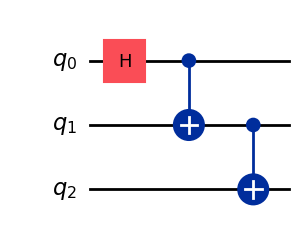

In [22]:
# Instantiate a quantum register with three qubits.
ghz_state_qr = QuantumRegister (3, 'q')

# Create a quantum circuit with a hadamard gate acting on qubit 0,
# a CNOT gate with control qubit 0 and target qubit 1,
# and a CNOT gate with control qubit 1 and target qubit 2. This will prepare a GHZ state.
ghz_state_qc = QuantumCircuit(ghz_state_qr)
ghz_state_qc.h(0)
ghz_state_qc.cx(0, 1)
ghz_state_qc.cx(1, 2)

# Draw the ciruit in mpl (matplotlib).
ghz_state_qc.draw("mpl")

In [23]:
rho_true = DensityMatrix.from_instruction(ghz_state_qc)
print("True density matrix:")
print(rho_true.data)

shadow_size = 1000
shadow = generate_classical_shadow(ghz_state_qc, shadow_size)
rho_shadow = reconstruct_state(shadow)
print("\nDensity matrix from shadow tomography:")
print(np.round(rho_shadow, 2))

print("\nDistance between the true and shadow tomography density matrices:")
print(np.round(operator_distance(rho_true.data, rho_shadow), 4))

print("\nTotal copies of the state used:")
print(shadow_size)

True density matrix:
[[0.5+0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0.5+0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0.5+0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0.5+0.j]]

Density matrix from shadow tomography:
[[ 0.47+0.j    0.  +0.01j  0.01+0.01j -0.09+0.01j -0.06+0.06j  0.02-0.01j
  -0.01-0.02j  0.5 +0.04j]
 [ 0.  -0.01j -0.01+0.j   -0.03-0.07j  0.  +0.01j -0.01-0.04j  0.04-0.03j
   0.02+0.j    0.01+0.04j]
 [ 0.01-0.01j -0.03+0.07j  0.  +0.j   -0.03+0.03j -0.  +0.01j  0.04-0.02j
   0.04+0.01j -0.06+0.j  ]
 [-0.09-0.01j  0.  -0.01j -0.03-0.03j  0.04+0.j    0.01+0.01j  0.02-0.01j
   0.01+0.05j -0.03-0.04j

### Using Classical Shadows to Estimate Observables

#### Function for estimating an arbitrary observable using a classical shadow

In [24]:
def estimate_observable(shadow, observable, k = 10):
    """
    Adapted from https://pennylane.ai/qml/demos/tutorial_classical_shadows/ and the original paper by Preskill.

    Given a classical shadow, a Pauli observable and value k, this function estimates the expectation value of the observable using median of means on k estimators.s

    Args:
        shadow (np.array): The classical shadow generated by the function generate_classical_shadow. The first element is a matrix of shape (shadow_size, num_qubits) where each row is a bit-string representing the result of a random Pauli measurement on the qubits. The second element is a matrix of shape (shadow_size, num_qubits) where each row is a sequence of integers representing the Pauli measurement scheme used to generate the corresponding bit-string in the first matrix.
        observable (np.array): The Pauli observable to estimate the expectation value of. In matrix form.
        k (int): The number of subsets to split the shadow into. The number of estimators. By default this is set to 10.

    Returns:
        float: The estimated expectation value of the observable.
    """

    # Unpack the shadow.
    measurements, measurement_schemes = shadow

    # Get the number of qubits.
    num_qubits = measurements.shape[1]

    if observable.shape[0] != 2**num_qubits or observable.shape[1] != 2**num_qubits:
        raise ValueError("The observable matrix must be of shape (2**num_qubits, 2**num_qubits).")

    # Split the shadow into k subsets.
    measurements_splits = np.array_split(measurements, k)
    measurement_schemes_splits = np.array_split(measurement_schemes, k)
    shadows = list(zip(measurements_splits, measurement_schemes_splits))

    # Array to store the estimated expectation values from each estimator.
    means = np.zeros(k, dtype=complex)

    # Iterate over the number of estimators. Calculate the expectation value of the observable for each estimator and store the result in the means array.
    for s, i in enumerate(shadows):
        means[s] = np.trace(observable @ reconstruct_state(i))
            
    # Return the median of the means.
    return np.median(means)

#### Function for estimating a Pauli observable using a classical shadow

*Talk about how this can be done faster than estimating an arbitrary observable*

In [25]:
def estimate_pauli_observable(shadow, observable, k = 10):
    """
    Adapted from https://pennylane.ai/qml/demos/tutorial_classical_shadows/ and the original paper by Preskill.

    Given a classical shadow, a Pauli observable and value k, this function estimates the expectation value of the observable using median of means on k estimators.s

    Args:
        shadow (np.array): The classical shadow generated by the function generate_classical_shadow. The first element is a matrix of shape (shadow_size, num_qubits) where each row is a bit-string representing the result of a random Pauli measurement on the qubits. The second element is a matrix of shape (shadow_size, num_qubits) where each row is a sequence of integers representing the Pauli measurement scheme used to generate the corresponding bit-string in the first matrix.
        observable (string): The observable to be estimated. In the form of a string representing the Pauli operator. For example, 'XX' represents the tensor product of two Pauli-X operators.
        k (int): The number of subsets to split the shadow into. The number of estimators. By default this is set to 10.

    Returns:
        float: The estimated expectation value of the observable.
    """

    # Unpack the shadow.
    measurements, measurement_schemes = shadow

    # Get the shadow size.
    shadow_size = measurements.shape[0]
    # Get the number of qubits.
    num_qubits = measurements.shape[1]

    # Check if the observable and the number of qubits in the shadow match. That is, the observable is a tensor product of Pauli operators acting on the same number of qubits as the shadow.
    if len(observable) != num_qubits:
        raise ValueError("The observable and the number of qubits in the shadow do not match.")

    # Edit the observable to do pattern matching with the measurement string. Replacing 'I' with the single character wild card '.'.
    observable = observable.replace('I', '.')

    # Split the shadow into k subsets.
    measurements_splits = np.array_split(measurements, k)
    measurement_schemes_splits = np.array_split(measurement_schemes, k)
    shadows = list(zip(measurements_splits, measurement_schemes_splits))

    # Array to store the estimated expectation values from each estimator.
    means = np.zeros(k)

    # Iterate over the number of estimators. Calculate the expectation value of the observable for each estimator and store the result in the means array.
    for s, shadow in enumerate(shadows):
        
        # Unpack the shadow k.
        measurements_k, measurement_schemes_k = shadow

        # Count the number of matches between the observable and the measurement schemes.
        match_indices = []
        for i, measurement_scheme_k in enumerate(measurement_schemes_k):

            # Convert the measurement scheme to a string to compare with the observable.
            measurement_scheme_string = ""
            for j in measurement_scheme_k:
                match j:
                    case 0:
                        measurement_scheme_string += 'X'
                    case 1:
                        measurement_scheme_string += 'Y'
                    case 2:
                        measurement_scheme_string += 'Z'

            # Check if the measurement scheme matches the observable.
            if re.match(observable, measurement_scheme_string):
                match_indices.append(i)

        # Catch the case that there are no matches.
        if len(match_indices) > 0:
            # Sum over the matches.
            sum = 0
            for match in match_indices:
                # Calculate the sign of the expectation for the single shot measurement.
                sign = 1
                for k, measurement_k in enumerate(measurements_k[match]):
                    if observable[k] in ['X', 'Z']:
                        sign *= measurement_k
                    elif observable[k] == 'Y':
                        sign *= (-1 * measurement_k)

                sum += sign*3**(len(list(filter(lambda x: x != '.', observable))))
        else:
            sum = 0
            
        # Store the result in the means array.
        means[s] = sum/len(measurement_schemes_k)


    # Return the median of the means.
    return np.median(means)

### Testing on some select Pauli observables

#### With an arbitrary single qubit state

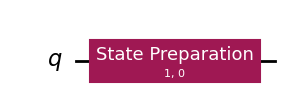

In [26]:
# Instantiate a quantum register for a single qubit.
single_qubit_qr = QuantumRegister(1, 'q')

# Coefficients for the arbitrary state.
a = 1
b = 0

# Create a quantum circuit which prepares the single qubit state into an arbitrary state based on coefficients a and b.
single_qubit_qc = QuantumCircuit(single_qubit_qr)
single_qubit_qc.prepare_state(state = [a/(np.sqrt(a**2 + b**2)), b/(np.sqrt(a**2 + b**2))], qubits = [0])

# Draw the circuit in mpl (matplotlib).
single_qubit_qc.draw('mpl')

In [27]:
I = np.matrix([[1,0],[0,1]]) # 2x2 Identity matrix
X = np.matrix([[0,1],[1,0]]) # Pauli-X matrix
Y = np.matrix([[0,-1j],[1j,0]]) # Pauli-Y matrix
Z = np.matrix([[1,0],[0,-1]]) # Pauli-Z matrix

observables = [I, X, Y, Z]

rho_true = DensityMatrix.from_instruction(single_qubit_qc)

shadow_size = 5000
shadow = generate_classical_shadow(single_qubit_qc, shadow_size)

for i in itertools.product(['I','X','Y','Z'], repeat = single_qubit_qc.num_qubits):
    observable_matrix = [1]
    for observable in i:
        match observable:
            case 'I':
                observable_matrix = np.kron(observable_matrix, I)
            case 'X':
                observable_matrix = np.kron(observable_matrix, X)
            case 'Y':
                observable_matrix = np.kron(observable_matrix, Y)
            case 'Z':
                observable_matrix = np.kron(observable_matrix, Z)
    
    true_expectation = np.trace(observable_matrix @ rho_true.data)
    print(f"True expectation value for the {''.join(i)} observable: " + str(np.round(np.real(true_expectation), decimals = 4)))

    estimated_expectation = estimate_pauli_observable(shadow, ''.join(i))
    print(f"Estimated expectation value for the {''.join(i)} observable: " + str(np.round(np.real(estimated_expectation), decimals = 4)))

    print("Difference between the true and shadow tomography expectation values: " + str(np.abs(true_expectation - estimated_expectation)) + "\n")

print("Total copies of the state used: " + str(shadow_size))

True expectation value for the I observable: 1.0
Estimated expectation value for the I observable: 1.0
Difference between the true and shadow tomography expectation values: 0.0

True expectation value for the X observable: 0.0
Estimated expectation value for the X observable: -0.045
Difference between the true and shadow tomography expectation values: 0.045

True expectation value for the Y observable: 0.0
Estimated expectation value for the Y observable: -0.012
Difference between the true and shadow tomography expectation values: 0.012

True expectation value for the Z observable: 1.0
Estimated expectation value for the Z observable: 0.975
Difference between the true and shadow tomography expectation values: 0.025000000000000022

Total copies of the state used: 5000


#### With a Bell state

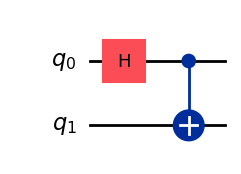

In [28]:
# Instantiate a quantum register with two qubits.
bell_state_qr = QuantumRegister (2, 'q')

# Create a quantum circuit with a hadamard gate acting on qubit 0
# and a CNOT gate with control qubit 0 and target qubit 1. This will prepare a bell state.
bell_state_qc = QuantumCircuit(bell_state_qr)
bell_state_qc.h(0)
bell_state_qc.cx(0, 1)

# Draw the ciruit in mpl (matplotlib).
bell_state_qc.draw("mpl")

In [29]:
I = np.matrix([[1,0],[0,1]]) # 2x2 Identity matrix
X = np.matrix([[0,1],[1,0]]) # Pauli-X matrix
Y = np.matrix([[0,-1j],[1j,0]]) # Pauli-Y matrix
Z = np.matrix([[1,0],[0,-1]]) # Pauli-Z matrix

observables = [I, X, Y, Z]

rho_true = DensityMatrix.from_instruction(bell_state_qc)

shadow_size = 5000
shadow = generate_classical_shadow(bell_state_qc, shadow_size)

for i in itertools.product(['I','X','Y','Z'], repeat = bell_state_qc.num_qubits):
    observable_matrix = [1]
    for observable in i:
        match observable:
            case 'I':
                observable_matrix = np.kron(observable_matrix, I)
            case 'X':
                observable_matrix = np.kron(observable_matrix, X)
            case 'Y':
                observable_matrix = np.kron(observable_matrix, Y)
            case 'Z':
                observable_matrix = np.kron(observable_matrix, Z)
    
    true_expectation = np.trace(observable_matrix @ rho_true.data)
    print(f"True expectation value for the {''.join(i)} observable: " + str(np.round(np.real(true_expectation), decimals = 4)))

    estimated_expectation = estimate_pauli_observable(shadow, ''.join(i))
    print(f"Estimated expectation value for the {''.join(i)} observable: " + str(np.round(np.real(estimated_expectation), decimals = 4)))

    print("Difference between the true and shadow tomography expectation values: " + str(np.abs(true_expectation - estimated_expectation)) + "\n")

print("Total copies of the state used: " + str(shadow_size))

True expectation value for the II observable: 1.0
Estimated expectation value for the II observable: 1.0
Difference between the true and shadow tomography expectation values: 2.220446049250313e-16

True expectation value for the IX observable: 0.0
Estimated expectation value for the IX observable: 0.018
Difference between the true and shadow tomography expectation values: 0.018

True expectation value for the IY observable: 0.0
Estimated expectation value for the IY observable: 0.054
Difference between the true and shadow tomography expectation values: 0.054

True expectation value for the IZ observable: 0.0
Estimated expectation value for the IZ observable: -0.018
Difference between the true and shadow tomography expectation values: 0.018

True expectation value for the XI observable: 0.0
Estimated expectation value for the XI observable: -0.033
Difference between the true and shadow tomography expectation values: 0.033

True expectation value for the XX observable: 1.0
Estimated expe

#### With a GHZ state

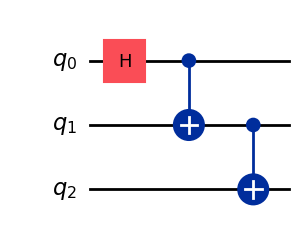

In [30]:
# Instantiate a quantum register with three qubits.
ghz_state_qr = QuantumRegister (3, 'q')

# Create a quantum circuit with a hadamard gate acting on qubit 0,
# a CNOT gate with control qubit 0 and target qubit 1,
# and a CNOT gate with control qubit 1 and target qubit 2. This will prepare a GHZ state.
ghz_state_qc = QuantumCircuit(ghz_state_qr)
ghz_state_qc.h(0)
ghz_state_qc.cx(0, 1)
ghz_state_qc.cx(1, 2)

# Draw the ciruit in mpl (matplotlib).
ghz_state_qc.draw("mpl")

In [31]:
I = np.matrix([[1,0],[0,1]]) # 2x2 Identity matrix
X = np.matrix([[0,1],[1,0]]) # Pauli-X matrix
Y = np.matrix([[0,-1j],[1j,0]]) # Pauli-Y matrix
Z = np.matrix([[1,0],[0,-1]]) # Pauli-Z matrix

observables = [I, X, Y, Z]

rho_true = DensityMatrix.from_instruction(ghz_state_qc)

shadow_size = 5000
shadow = generate_classical_shadow(ghz_state_qc, shadow_size)

for i in itertools.product(['I','X','Y','Z'], repeat = ghz_state_qc.num_qubits):
    observable_matrix = [1]
    for observable in i:
        match observable:
            case 'I':
                observable_matrix = np.kron(observable_matrix, I)
            case 'X':
                observable_matrix = np.kron(observable_matrix, X)
            case 'Y':
                observable_matrix = np.kron(observable_matrix, Y)
            case 'Z':
                observable_matrix = np.kron(observable_matrix, Z)
    
    true_expectation = np.trace(observable_matrix @ rho_true.data)
    print(f"True expectation value for the {''.join(i)} observable: " + str(np.round(np.real(true_expectation), decimals = 4)))

    estimated_expectation = estimate_pauli_observable(shadow, ''.join(i))
    print(f"Estimated expectation value for the {''.join(i)} observable: " + str(np.round(np.real(estimated_expectation), decimals = 4)))

    print("Difference between the true and shadow tomography expectation values: " + str(np.abs(true_expectation - estimated_expectation)) + "\n")

print("Total copies of the state used: " + str(shadow_size))

True expectation value for the III observable: 1.0
Estimated expectation value for the III observable: 1.0
Difference between the true and shadow tomography expectation values: 2.220446049250313e-16

True expectation value for the IIX observable: 0.0
Estimated expectation value for the IIX observable: -0.018
Difference between the true and shadow tomography expectation values: 0.018000000000000002

True expectation value for the IIY observable: 0.0
Estimated expectation value for the IIY observable: -0.033
Difference between the true and shadow tomography expectation values: 0.033

True expectation value for the IIZ observable: 0.0
Estimated expectation value for the IIZ observable: 0.003
Difference between the true and shadow tomography expectation values: 0.002999999999999999

True expectation value for the IXI observable: 0.0
Estimated expectation value for the IXI observable: -0.021
Difference between the true and shadow tomography expectation values: 0.020999999999999998

True exp

***
## Testing Sample and Computational Complexity

In the supplementary information document I showed that in order to estimate the expectation values of $M$ observables with maximum $k$ locality and maximum error $\epsilon$ a the sample complex is given by:
$$ .$$
I also showed that the classical computational complexity for the same situation is given by:
$$ .$$
In the below numerical examples I intend to demonstrate that these trends appear as expected.

### 

***
## Performance Comparison

The reason shadow tomography is appealing is because it supposedly offers a performance increase over traditional complete state tomography. For the paradigm I chose (random local pauli measurements) the size of the classical shadow required to estimate $M$ observables each with locality $L_i$ scales with:
$$ N_{tot} = \mathcal{O} \left( \frac{\log{(M)}}{\epsilon^2} \max_{1 \leq i \leq M} 4^{L_i} ||O_i||^2_\infty \right) $$
Where $ ||O||_\infty$ is the infinity norm and $\epsilon$ is the largest additive error we wish to estimate our observables within. More details are given in [Predicting Many Properties of a Quantum System from Very Few Measurements](#references). It is important to indicate that to obtain this scaling the estimation is done by median of means. With $K$ estimators of size $N$:
$$ K = 2 \log{\left(\frac{2M}{\delta}\right)} \quad \text{and} \quad N \leq \frac{34}{\epsilon^2} \max_{1 \leq i \leq M} 4^{L_i} ||O_i||^2_\infty $$
Where $\delta$ is the probability of failure of the error bound.

>Note: The above is all from [Predicting Many Properties of a Quantum System from Very Few Measurements](#references).

When using the above to calculate to total number of state copies needed to satisfy an error bound of $\epsilon = 0.01$ you will obtain a shadow with size on the order of $10^7$. This very large, much larger than the shadows used in the numerical experiments of [Predicting Many Properties of a Quantum System from Very Few Measurements](#references). Therefore, while it may be true that a shadow with size calculated using the equations above is guaranteed to satisfy the desired maximum error a much smaller shadow can still perform favorably. Below I will calculate two point correlation functions using complete state tomography and shadow tomography on the same number of state copies and compare the maximum error of both methods. 

#### Function for generating all 2-point observables.

In [32]:
def two_point_paulis(num_qubits):
    """
    Generate a list of two-point Pauli observables for a given number of qubits.

    Args:
        num_qubits (int): The number of qubits.

    Returns:
        list: A list of two-point Pauli observables.
    """

    # List to store the observables.
    observables = []    

    # Loop over the iterator of the cartesian product of the Pauli operators.
    for i in itertools.product(['I','X','Y','Z'], repeat = num_qubits):
            
        # Filter all the observables that are not two qubit observables.
        if((num_qubits - ''.join(i).count('I')) != 2):
            continue
        else:
            # Append the observable to the list.
            observables.append(''.join(i))

    return observables

#### Function for converting the string representation of the operator to the matrix representation

In [33]:
def pauli_string_to_matrix(pauli_string):
    """
    Convert a Pauli string to a matrix representation.

    Args:
        pauli_string (str): The Pauli string to convert to a matrix.

    Returns:
        np.array: The matrix representation of the Pauli string.
    """

    # The Pauli matrices.
    I = np.array([[1,0],[0,1]])
    X = np.array([[0,1],[1,0]])
    Y = np.array([[0,-1j],[1j,0]])
    Z = np.array([[1,0],[0,-1]])

    # Map the Pauli string to the corresponding Pauli matrix.
    paulis = { 'I': I, 'X': X, 'Y': Y, 'Z': Z }

    # Array to store the matrix representation of the Pauli string.
    observable_matrix = np.array([1])

    # Construct the matrix representation of the observable.
    for observable in pauli_string:
        observable_matrix = np.kron(observable_matrix, paulis[observable])

    return observable_matrix

#### Function for calculating the infinity matrix norm

In [34]:
def mat_inf_norm(A):
    """
    Calculate the infinity norm of a matrix.

    Args:
        A (np.array): The matrix to calculate the infinity norm of.

    Returns:
        float: The infinity norm of the matrix.
    """

    return np.linalg.norm(A, ord = np.inf)

#### Function for calculating the required shadow size

In [35]:
def shadow_bound(error, observables, failure_rate = 0.01):
    """
    Adapted from https://pennylane.ai/qml/demos/tutorial_classical_shadows/ and the original paper by Preskill.
    
    Given an error bound, a set of observables and a failure rate, this function calculates the number of copies of the state required to achieve the error bound with the given failure rate.

    Args:
        error (float): The error bound.
        observables (list): A list of observables to estimate the expectation values of. Observables are given as strings representing the Pauli operators. For example, 'XX' represents the tensor product of two Pauli-X operators.
        failure_rate (float): The failure rate. By default this is set to 0.01.

    Returns:
        int: The number of copies of the state required to achieve the error bound with the given failure rate.
        int: The number of estimators used to estimate the expectation values to achieve the given failure rate.
    """

    # The number of observables.
    M = len(observables)

    # The number of estimators.
    K = 2*np.log(2*M/failure_rate)

    # Find the observable that maximizes the right most term in the equation for the size of each estimator.
    max_term = 0
    for i in observables:

        observable_matrix = pauli_string_to_matrix(i)

        # Number of qubits the observable acts on non-trivially.           
        locality = len(i.replace('I', ''))

        # Calculate the right most term in the equation for the size of each estimator.
        temp = 4**locality * mat_inf_norm(observable_matrix)**2

        # Update the maximum term.
        if temp > max_term:
            max_term = temp

    # Calculate the size of each estimator.
    N = (34/error**2) * max_term

    return int(np.ceil(K * N)), int(K)

In [36]:
def expected_max_error(N):
    return np.sqrt(34/N * 4**2)

### The Two Qubit Case

#### With a Bell state

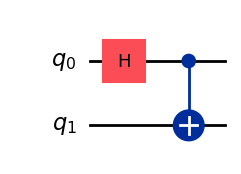

In [37]:
# Instantiate a quantum register with two qubits.
bell_state_qr = QuantumRegister (2, 'q')

# Create a quantum circuit with a hadamard gate acting on qubit 0
# and a CNOT gate with control qubit 0 and target qubit 1. This will prepare a bell state.
bell_state_qc = QuantumCircuit(bell_state_qr)
bell_state_qc.h(0)
bell_state_qc.cx(0, 1)

# Draw the ciruit in mpl (matplotlib).
bell_state_qc.draw("mpl")

In [49]:
# An array of the total number of state copies to take measurements on.
shots_list = range(640, 640*10, 160)

# Generate the 2-qubit Pauli observables.
observables = two_point_paulis(bell_state_qc.num_qubits)

# Get the true density matrix of the state.
true_state = DensityMatrix.from_instruction(bell_state_qc)

# Compute the true expectation values of the observables.
true_expectations = []
for observable in observables:
    observable_matrix = pauli_string_to_matrix(observable)
    true_expectations.append(np.trace(observable_matrix @ true_state.data))

# Lists to store the maximum error for each number of shots for each estimation method.
max_tomography_error = []
max_shadow_error = []

# Lists to store the execution times for each estimation method.
tomography_times = []
shadow_times = []

for shots in shots_list:

    ################################################################################################################

    # Compute density matrix from complete state tomography.
    tomography_state = complete_state_tomography(bell_state_qc, int(shots/16))

    # Estimate all the two-point Pauli observables using the density matrix generated by complete state tomography.
    tomography_expectations = []

    code_to_time = """for observable in observables:
        observable_matrix = pauli_string_to_matrix(observable)
        tomography_expectations.append(np.trace(observable_matrix @ tomography_state))
    """

    tomography_times.append(timeit.timeit(stmt = code_to_time, globals = locals(), number = 1))
    ################################################################################################################

    # Compute the maximum error for the tomography method.
    max_tomography_error.append(np.max(np.abs(np.array(true_expectations) - np.array(tomography_expectations))))

    ################################################################################################################

    # Generate the classical shadow. There is a large performance overhead for this so I will only time the estimation of the observables.
    shadow = generate_classical_shadow(bell_state_qc, shots)

    # Estimate all the two-point Pauli observables using the classical shadow.
    shadow_expectations = []

    code_to_time = """for observable in observables:
        shadow_expectations.append(estimate_pauli_observable(shadow, observable))
    """

    shadow_times.append(timeit.timeit(stmt = code_to_time, globals = locals(), number = 1))
    ################################################################################################################

    # Compute the maximum error for the shadow method.
    max_shadow_error.append(np.max(np.abs(np.array(true_expectations) - np.array(shadow_expectations))))



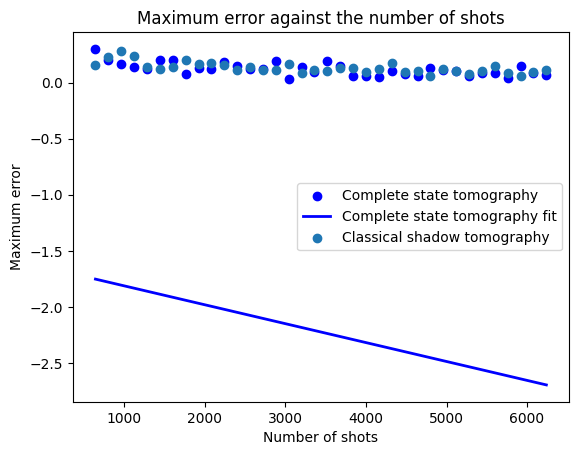

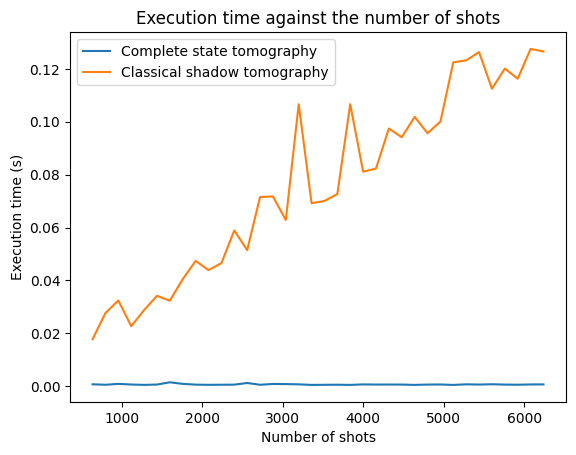

In [57]:
# Plots
# Plot the maximum error for each estimation method against the number of shots.
plt.scatter(shots_list, max_tomography_error, label = "Complete state tomography", color = "b")
b, a = np.polyfit(shots_list, np.log(max_tomography_error), deg = 1)
plt.plot(shots_list, a + b * shots_list, label = "Complete state tomography fit", color = "b", lw = 2)
plt.scatter(shots_list, max_shadow_error, label = "Classical shadow tomography")
plt.xlabel("Number of shots")
#plt.xscale("log")
plt.ylabel("Maximum error")
#plt.yscale("log")
plt.title("Maximum error against the number of shots")
plt.legend()
plt.show()

# Plot the execution times for each estimation method against the number of shots.
plt.plot(shots_list, tomography_times, label = "Complete state tomography")
plt.plot(shots_list, shadow_times, label = "Classical shadow tomography")
plt.xlabel("Number of shots")
plt.ylabel("Execution time (s)")
plt.title("Execution time against the number of shots")
plt.legend()
plt.show()

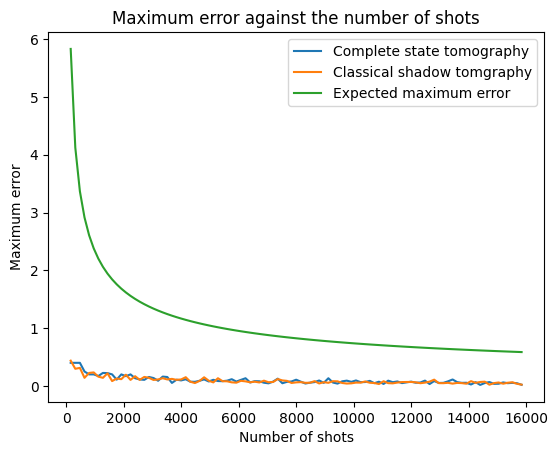

In [ ]:
errors = expected_max_error(np.array(shots_list)/10)

# Plot the maximum error for each estimation method against the number of shots.
plt.plot(shots_list, max_tomography_error, label = "Complete state tomography")
plt.plot(shots_list, max_shadow_error, label = "Classical shadow tomgraphy")
plt.plot(shots_list, errors, label = "Expected maximum error")
plt.xlabel("Number of shots")
plt.ylabel("Maximum error")
plt.title("Maximum error against the number of shots")
plt.legend()
plt.show()

### The Three Qubit Case

#### With a GHZ state

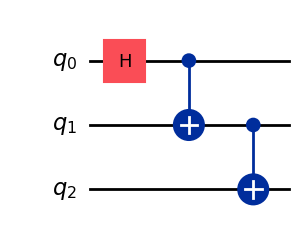

In [ ]:
# Instantiate a quantum register with three qubits.
ghz_state_qr = QuantumRegister (3, 'q')

# Create a quantum circuit with a hadamard gate acting on qubit 0,
# a CNOT gate with control qubit 0 and target qubit 1,
# and a CNOT gate with control qubit 1 and target qubit 2. This will prepare a GHZ state.
ghz_state_qc = QuantumCircuit(ghz_state_qr)
ghz_state_qc.h(0)
ghz_state_qc.cx(0, 1)
ghz_state_qc.cx(1, 2)

# Draw the ciruit in mpl (matplotlib).
ghz_state_qc.draw("mpl")

In [ ]:
# An array of the total number of state copies to take measurements on. All multiples of 64 = 4^3 ensures that the number of shots divides evenly into the number of expectation values the complete state tomography method estimates.
shots_list = range(640, 64000, 640)

# Generate the 2-qubit Pauli observables.
observables = two_point_paulis(ghz_state_qc.num_qubits)

# Get the true density matrix of the state.
true_state = DensityMatrix.from_instruction(ghz_state_qc)

# Compute the true expectation values of the observables.
true_expectations = []
for observable in observables:
    observable_matrix = pauli_string_to_matrix(observable)
    true_expectations.append(np.trace(observable_matrix @ true_state.data))

# Lists to store the maximum error for each number of shots for each estimation method.
max_tomography_error = []
max_shadow_error = []

# Lists to store the execution times for each estimation method.
tomography_times = []
shadow_times = []

for shots in shots_list:

    ################################################################################################################
    start = time.time()

    # Compute density matrix from complete state tomography.
    tomogaphy_state = complete_state_tomography(ghz_state_qc, int(shots/16))

    # Estimate all the two-point Pauli observables using the density matrix generated by complete state tomography.
    tomography_expectations = []
    for observable in observables:
        observable_matrix = pauli_string_to_matrix(observable)
        tomography_expectations.append(np.trace(observable_matrix @ tomogaphy_state))

    end = time.time()

    tomography_times.append(end - start)
    ################################################################################################################

    # Compute the maximum error for the tomography method.
    max_tomography_error.append(np.max(np.abs(np.array(true_expectations) - np.array(tomography_expectations))))

    ################################################################################################################
    start = time.time()

    # Generate the classical shadow.
    shadow = generate_classical_shadow(ghz_state_qc, shots)

    # Estimate all the two-point Pauli observables using the classical shadow.
    shadow_expectations = []
    for observable in observables:
        shadow_expectations.append(estimate_pauli_observable(shadow, observable))

    end = time.time()

    shadow_times.append(end - start)
    ################################################################################################################

    # Compute the maximum error for the shadow method.
    max_shadow_error.append(np.max(np.abs(np.array(true_expectations) - np.array(shadow_expectations))))

# Plots
# Plot the maximum error for each estimation method against the number of shots.
plt.plot(shots_list, max_tomography_error, label = "Complete state tomography")
plt.plot(shots_list, max_shadow_error, label = "Classical shadow tomgraphy")
plt.xlabel("Number of shots")
plt.ylabel("Maximum error")
plt.title("Maximum error against the number of shots")
plt.legend()
plt.show()

# Plot the execution times for each estimation method against the number of shots.
plt.plot(shots_list, tomography_times, label = "Complete state tomography")
plt.plot(shots_list, shadow_times, label = "Classical shadow tomgraphy")
plt.xlabel("Number of shots")
plt.ylabel("Execution time (s)")
plt.title("Execution time against the number of shots")
plt.legend()
plt.show()


KeyboardInterrupt: 

## Extras

### Testing the distribution of simulated randomness in Qiskit.
To determine if there is any bias in the random numbers Qiskit uses to simulate the quantum circuits I will prepare a 10 qubit circuit which prepares each qubit in an equal superposition of $\ket{0}$ and $\ket{1}$ basis states. Then in measuring I should expect, over a large enough number of measurements, that the measured bit-strings be uniformly distributed.
> Note: The apparent missing bars in the bar plot are just an artifact of the plotting function plotting such thin lines.

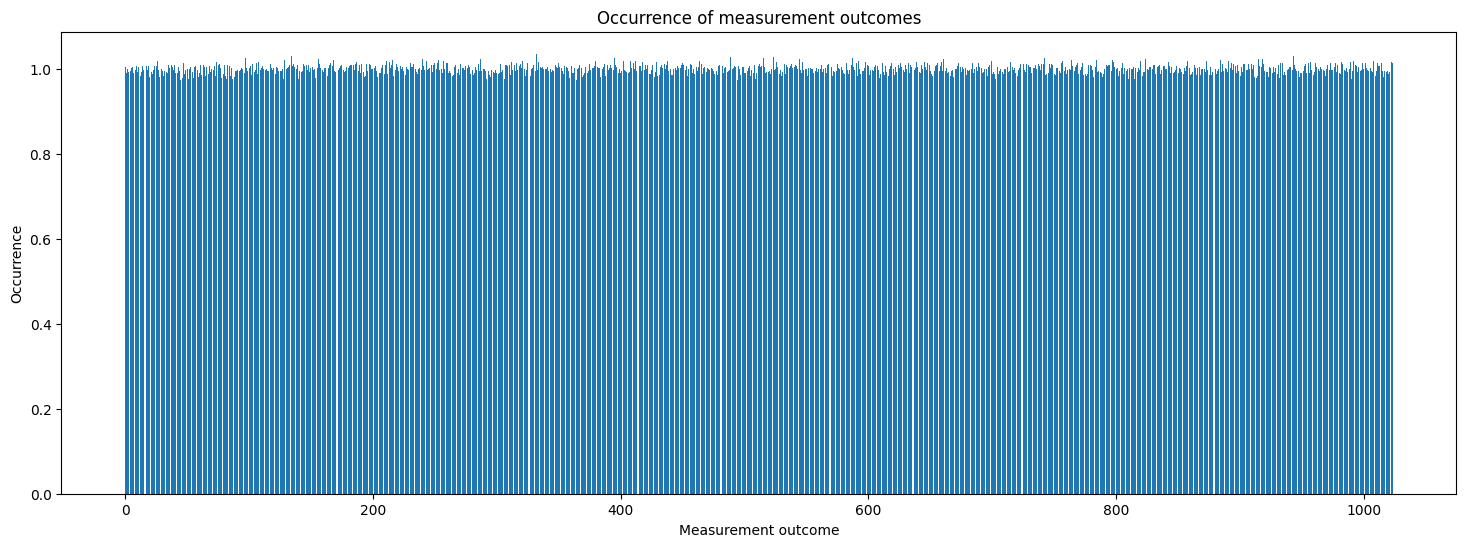

In [17]:
num_qubits = 10
shots = 10000000

# An array to store the occurrence of each measurement outcome (normalized to 1). The index is the decimal representation of the measurement outcome.
occurrence = np.zeros(2**num_qubits)

qc = QuantumCircuit(num_qubits) # Create a quantum circuit with 20 qubits.

# Apply the Hadamard gate to each qubit. This prepares the qubits in a superposition of the |0> and |1> states.
for i in range(num_qubits):
    qc.h(i)

qc.measure_all() # Measure all the qubits.

sampler = StatevectorSampler(default_shots=shots) # Create a sampler to simulate the quantum circuit many shots.

# Run the sampler on the quantum circuit and store the result.
result = sampler.run([qc]).result()[0]

counts = result.data.meas.get_counts() # Get the counts of the measurement outcomes.

# Iterate over the counts of the measurement outcomes.
for count in counts:
    decimal = int(count, 2) # Convert the binary string to a decimal number.
    occurrence[decimal] = counts[count]/(shots/(2**num_qubits)) # Normalize the occurrence of the measurement outcome.

# Plot the occurrence of each measurement outcome.
plt.figure(figsize=(18, 6))
plt.bar(range(2**num_qubits), occurrence)
plt.xlabel("Measurement outcome")
plt.ylabel("Occurrence")
plt.title("Occurrence of measurement outcomes")
plt.show()

## References
1. [Predicting Many Properties of a Quantum System from Very Few Measurements](https://arxiv.org/pdf/2002.08953)
2. [Shadow Tomography of Quantum States](https://www.scottaaronson.com/papers/batch.pdf)
3. [Quantum State Tomography](https://research.physics.illinois.edu/QI/Photonics/tomography-files/tomo_chapter_2004.pdf)
4. [PennyLane Classical Shadows Demo](https://pennylane.ai/qml/demos/tutorial_classical_shadows/#huang2020)
5. [Qiskit API Reference](https://docs.quantum.ibm.com/api/qiskit)